In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

import warnings
warnings.simplefilter('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Colab Notebooks
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
 abalone.data.txt
 None
'None (1)'
 test.csv
 train.csv
 Zarina_task1.ipynb
 Zarina_task2.ipynb
'Копия блокнота "itmo_course_base_models.ipynb"'
'Копия блокнота "itmo_course_eda.ipynb"'
'Копия блокнота "itmo_course_ensemble_models.ipynb"'
'Копия блокнота "itmo_course_feature_engineering.ipynb"'
'Копия блокнота "itmo_course_jupyter.ipynb"'
'Копия блокнота "itmo_course_metrics.ipynb"'
'Копия блокнота "itmo_course_ml_categorical_encoding.ipynb"'
'Копия блокнота "itmo_course_numpy_pandas.ipynb"'
'Копия блокнота "itmo_course_params_optimization_sklearn.ipynb"'
'Копия блокнота "itmo_course_pytorch_quickstart_tutorial.ipynb"'
'Копия блокнота "Untitled0.ipynb"'


In [4]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train.csv')
data.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

**Some comments on labels:** \
battery_powerTotal -- energy a battery can store in one time measured in mAh;\
blue -- Has bluetooth or not;\
clock_speed -- speed at which microprocessor executes instructions ;\
fc -- Front Camera mega pixels;\
int_memory -- Internal Memory in Gigabytes;\
m_dep -- Mobile Depth in cm;\
mobile_wt -- Weight of mobile phone (in gramms suppose);\
pc -- Primary Camera mega pixels;\
px_height(width) -- Pixel Resolution Height (width);

##Split and scale

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='price_range'),
    data['price_range'],
    random_state=2023,
    test_size=0.25
)

In [6]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [7]:
X_train_short, X_valid_short, y_train_short, y_valid_short = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=2023)

In [8]:
X_train_short.shape

(1125, 20)

In [9]:
X_test_scaled.shape

(500, 20)

In [10]:
X_valid_short.shape

(375, 20)

In [11]:
data.shape

(2000, 21)

##Random Forest

**RandomForestClassifie**r fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [12]:
rf = RandomForestClassifier(random_state=2023)
rf.fit(X_train_short, y_train_short)
y_val_preds = rf.predict(X_valid_short)
print(classification_report(y_valid_short,y_val_preds))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        94
           1       0.86      0.79      0.82       104
           2       0.83      0.84      0.84        83
           3       0.95      0.96      0.95        94

    accuracy                           0.88       375
   macro avg       0.88      0.88      0.88       375
weighted avg       0.88      0.88      0.88       375



**Results of LogisticRegression from Task 1 applied to the scaled dataset:**\
              precision   recall   f1-score    support

           0       0.94      0.99      0.96       149
           1       0.75      0.74      0.74       129
           2       0.81      0.68      0.74       160
           3       0.89      0.99      0.94       162

    accuracy                           0.85       600
    macro avg      0.85      0.85      0.85       600
    weighted avg   0.85      0.85      0.85       600

**Results of LogisticRegression from Task 1 after reduction of the number of features:**\
  precision    recall  f1-score   support

           0       0.95      1.00      0.97       149
           1       0.83      0.85      0.84       129
           2       0.91      0.71      0.80       160
           3       0.87      1.00      0.93       162

    accuracy                           0.89       600
    macro avg      0.89      0.89      0.89       600
    weighted avg   0.89      0.89      0.89       600

As one can see, the RandomForestClassifier before optimization shows contradictory results. For example, class 0 is predicted worse, while for class 2 re-call is higher compared with LogisticRegression after reduction of dataset.

##Hyperparameters

In [13]:
parameters = {
    'n_estimators': np.arange(50, 160, 20),# optimal amount of trees
    'max_depth': list(range(3, 11)),# depth of tree is limited by range(); Length is not limited by [None]?
    'random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=3,
)

In [14]:
%%time
grid_search.fit(X_train_short, y_train_short)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
max_depth: 10
n_estimators: 110
random_state: 2023
CPU times: user 1.01 s, sys: 142 ms, total: 1.16 s
Wall time: 34.1 s


##Validation with best parameters

In [15]:
y_val_opt_preds = grid_search.best_estimator_.predict(X_valid_short)
print(classification_report(y_valid_short,y_val_preds))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        94
           1       0.86      0.79      0.82       104
           2       0.83      0.84      0.84        83
           3       0.95      0.96      0.95        94

    accuracy                           0.88       375
   macro avg       0.88      0.88      0.88       375
weighted avg       0.88      0.88      0.88       375



We obtain higher recall and f1-score for class 2, manifesting about increase of the recall and precision's mean values. Characterics of other classes decrease a bit, but in general, the baseline shows more balanced results.

## Interpretation

###Mean Decrease Impurity

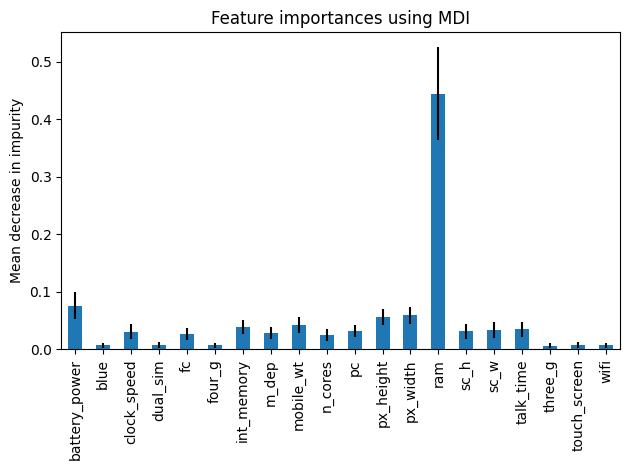

In [17]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train_short.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

As we see, the most crusial feature is ram. Among others, we can select battery_power, px-features too. The same results we obtain from correlation matrix in Task1, where we manualy reduced datasest to ["battery_power","px_height","px_width","ram"]. The reduced dataset improved metrics of Logistic Regression. Thus, we confirm our previous decision to cut data. Let's check the validation dataset:

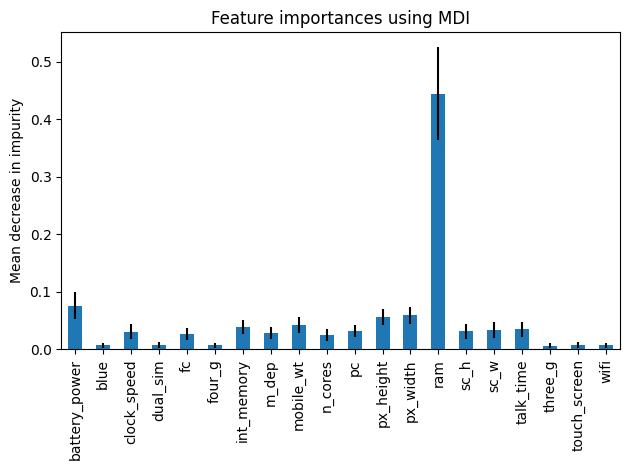

In [20]:
forest_importances = pd.Series(rf.feature_importances_, index=X_valid_short.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

Test for grid_search.best_estimator_

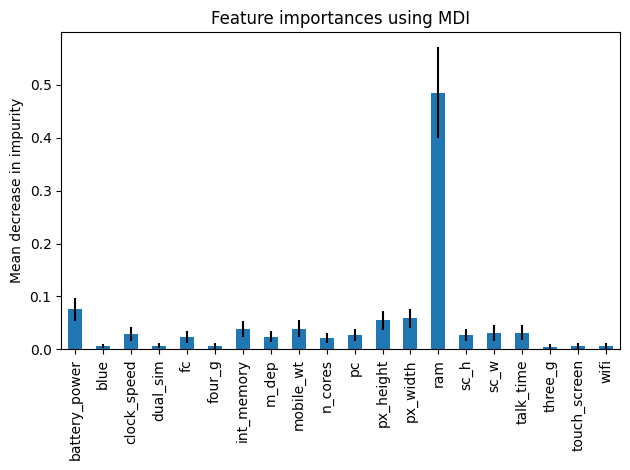

In [21]:
rf_best=grid_search.best_estimator_
forest_importances = pd.Series(rf_best.feature_importances_, index=X_valid_short.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

###Permutation importances (for the optimized parameters)

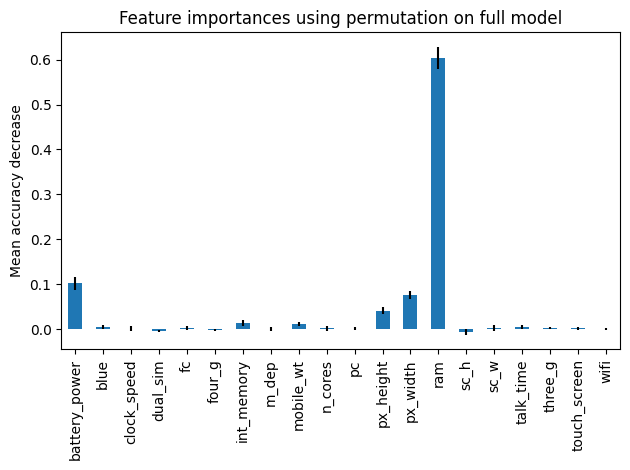

In [24]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(rf_best, X_valid_short, y_valid_short, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

With the permutation importances we confirm, that only "battery_power","px_height","px_width","ram" affect the prediction.

## Test

In [16]:
y_test_preds = grid_search.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test,y_test_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       124
           1       0.82      0.88      0.85       102
           2       0.85      0.79      0.82       134
           3       0.90      0.89      0.90       140

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



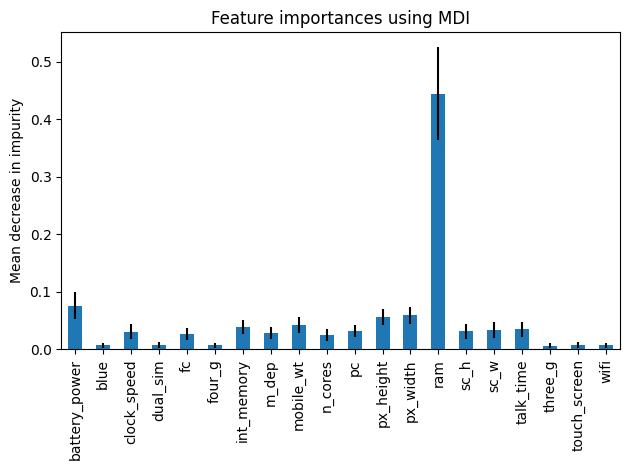

In [19]:
forest_importances = pd.Series(rf.feature_importances_, index=X_test_scaled.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

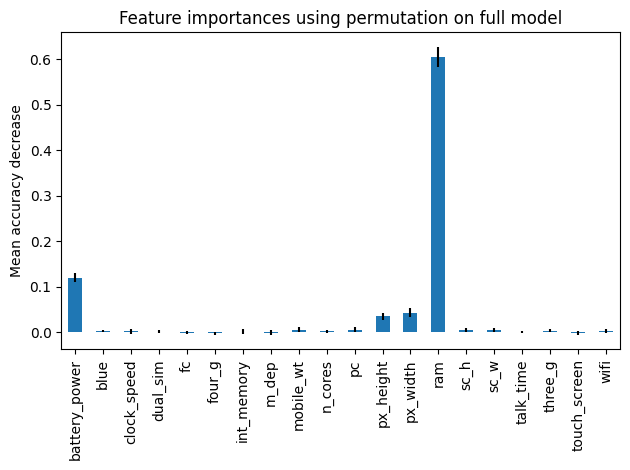

In [23]:
importances = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Summary
Here we find out two baseline models that predicts the class comparable: LogisticRegression on cutted dataset ("battery_power","px_height","px_width","ram") and RandomforestClassifier with optimized hyperparameters. Interpretation confirm the selection of features "battery_power","px_height","px_width","ram". There is an advantage of the RandomforestClassifier -- it predictions are more balanced over all classes compared to simlpe LogisticRegression.